In [2]:
from natsort import natsorted

## sys
import random
import time
from glob import glob
import json


## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

In [61]:
def dict2tensor(d, fill=None):
    n = len(d.keys())
    k2i = {k:i for i,k in enumerate(natsorted(d.keys()))}
    res = torch.zeros(len(d.keys()), len(d.keys()), device=device)
    for src_node, dst_nodes in d.items():
        for dst_node, distance in dst_nodes.items():
            if fill is not None:
                res[k2i[src_node],k2i[dst_node]] = fill
            else:
                res[k2i[src_node],k2i[dst_node]] = distance
    return res, k2i


def graph2json(G,D,W, initPositions):
    return {
        'nodes': [
            {
                'index':i, 
                'id': n,
                'x': initPositions[i]['x'],
                'y': initPositions[i]['y'],
            } 
            for i, n in enumerate(G.nodes)
        ],
        'edges': [
            {
                'source': e1, 
                'target': e2
            } 
            for e1,e2 in G.edges
        ],
        'weight': W.cpu().numpy().tolist(),
        'graphDistance': D.cpu().numpy().tolist(),
    }

## generate a graph

In [63]:
fns = natsorted(
    glob('_tsne_output/*.json')
    +glob('_neato_sfdp_layouts0/*.dot'),
    key=lambda x:x.split('/')[-1]
)
fns = [fn for fn in fns if 'grid' in fn and 'tnse']
fns


['_neato_sfdp_layouts0/grid_neato.dot',
 '_neato_sfdp_layouts0/grid_sfdp.dot',
 '_tsne_output/grid_tsne.json']

In [75]:
G.nodes

NodeView(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', 0, 2, 5, 24, 1, 10, 17, 15, 4, 11, 3, 20, 13, 14, 8, 6, 7, 12, 9, 19, 22, 23, 21, 16, 18))

In [99]:

for fn in fns:
    print(' in: ' + fn)
    with open(fn) as f:
        graph = json.load(f)
    print(graph['nodes'])
    for n in graph['nodes']:
        n['id'] = str(n['id'])
        
    for e in graph['edges']:
        e['source'] = str(e['source'])
        e['target'] = str(e['target'])
        
    for p in graph['initPositions']:
        p['id'] = str(p['id'])
    
    for d, pos in zip(graph['nodes'], graph['initPositions']):
        assert d['id'] == pos['id'], f"{d['id']} != {pos['id']}"
        d['x'] = pos['x']
        d['y'] = pos['y']
        

    
    graph['nodes'] = natsorted(graph['nodes'], key=lambda x:x['id'])
    
    for n in graph['nodes']:
        print(n)
    nodes = [n['id'] for n in graph['nodes']]
    
    print(nodes)
    edges = [[e['source'], e['target']] for e in graph['edges']]
    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    nodeCount = len(G.nodes)
    D, k2i = dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
    Adj,_ = dict2tensor(dict(G.adjacency()), fill=1)
    
    eye = torch.eye(nodeCount, device=device)
    W = 1/(D**2+eye)
    print(len(G.nodes), len(graph['nodes']))
    js = graph2json(G, D, W, graph['nodes'])
    fnout = fn.split('/')[-1].replace('.dot', '.json')
    if 'neato' in fnout:
        fnout = 'neato_layouts/' + fnout
    elif 'sfdp' in fnout:
        fnout = 'sfdp_layouts/' + fnout
    elif 'tsne' in fnout:
        fnout = 'tsne_layouts/' + fnout
    else:
        raise Exception
        
    with open(fnout, 'w') as f:
        json.dump(js, f, indent=2)
        print(f'out: {fnout}')
        print()
        
        
    if 'neato.dot' in fn:
        init_neato = [[d['x'], d['y']] for d in graph['nodes']]
    if 'sfdp.dot' in fn:
        init_sfdp = [[d['x'], d['y']] for d in graph['nodes']]
#     if 'tsne.json' in fn:
#         init_tsne = [[d['x'], d['y']] for d in graph['nodes']]
        
        js['initPosition_neato'] = init_neato
        js['initPosition_sfdp'] = init_sfdp
#         js['initPosition_tsne'] = init_tsne
        
        fnout = '_'.join(fnout.split('/')[-1].split('_')[:-1]) + '.json'
        with open(fnout, 'w') as f:
            json.dump(js, f, indent=2)
            print('out: ' + fnout)
        print('-'*20)
        

 in: _neato_sfdp_layouts0/grid_neato.dot
[{'index': 0, 'id': '(4, 0)'}, {'index': 1, 'id': '(2, 0)'}, {'index': 2, 'id': '(0, 3)'}, {'index': 3, 'id': '(4, 3)'}, {'index': 4, 'id': '(1, 0)'}, {'index': 5, 'id': '(4, 1)'}, {'index': 6, 'id': '(3, 0)'}, {'index': 7, 'id': '(1, 4)'}, {'index': 8, 'id': '(2, 4)'}, {'index': 9, 'id': '(1, 3)'}, {'index': 10, 'id': '(3, 4)'}, {'index': 11, 'id': '(0, 1)'}, {'index': 12, 'id': '(3, 3)'}, {'index': 13, 'id': '(3, 2)'}, {'index': 14, 'id': '(2, 3)'}, {'index': 15, 'id': '(0, 4)'}, {'index': 16, 'id': '(3, 1)'}, {'index': 17, 'id': '(4, 4)'}, {'index': 18, 'id': '(4, 2)'}, {'index': 19, 'id': '(0, 2)'}, {'index': 20, 'id': '(1, 1)'}, {'index': 21, 'id': '(0, 0)'}, {'index': 22, 'id': '(2, 2)'}, {'index': 23, 'id': '(2, 1)'}, {'index': 24, 'id': '(1, 2)'}]
{'index': 21, 'id': '(0, 0)', 'x': 45.949, 'y': -233.07}
{'index': 11, 'id': '(0, 1)', 'x': 93.981, 'y': -165.28}
{'index': 19, 'id': '(0, 2)', 'x': 141.93, 'y': -95.434}
{'index': 2, 'id': '(0

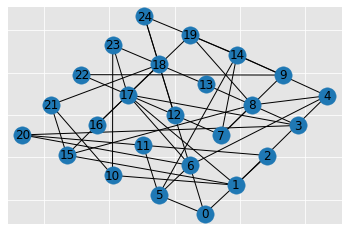

In [96]:
nx.draw_networkx(G, pos={str(i):pos for i,pos in enumerate(init_neato)})

NodeView(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'))